In [3]:
!pip install wordcloud
!conda install -y gensim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix

Jupyter detected...
3 channel Terms of Service accepted
Channels:
 - defaults
Platform: win-64
Solving environment: done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
    current version: 25.5.1
    latest version: 25.9.1

Please update conda by running

    $ conda update -n base -c defaults conda




In [4]:
df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")

In [5]:
# Setting up a target variable and combining both the real and fake news datasets
df_true['target'] = 1
df_fake['target'] = 0
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df['original'] = df['title'] + ' ' + df['text']
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  target  \
0  December 31, 2017        1   
1  December 29, 2017        1   
2  December 31, 2017        1   
3  December 30, 2017        1   
4  December 29, 2017        1   

                                            original  
0  As U.S. budget fight looms, Republicans flip t...  
1  U.S. military to accept transgender recruits o...  
2  Senior U.S. Republican senator: 'Let Mr. Muell...  
3  FBI Russia probe helped by Australian diplomat...  
4  Trump wants Postal Service to charge 'much mor...

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     44898 non-null  object
 1   text      44898 non-null  object
 2   subject   44898 non-null  object
 3   date      44898 non-null  object
 4   target    44898 non-null  int64 
 5   original  44898 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.1+ MB


In [7]:
df.shape

(44898, 6)

In [8]:
df.isnull().sum()

title       0
text        0
subject     0
date        0
target      0
original    0
dtype: int64

In [9]:
df['title'][2188]

"Trump orders probe of China's intellectual property practices"

In [10]:
df['text'][2188]

'WASHINGTON (Reuters) - President Donald Trump on Monday authorized an inquiry into China’s alleged theft of intellectual property in the first direct trade measure by his administration against Beijing, but one that is unlikely to prompt near-term change. Trump broke from his 17-day vacation in New Jersey to sign the memo in the White House at a time of heightened tensions between Washington and Beijing over North Korea’s nuclear ambitions. The investigation is likely to cast a shadow over relations with China, the largest U.S. trading partner, just as Trump is asking Beijing to step up pressure against Pyongyang.  U.S. Trade Representative Robert Lighthizer will have a year to look into whether to launch a formal investigation of China’s trade policies on intellectual property, which the White House and U.S. industry lobby groups say are harming U.S. businesses and jobs. Trump called the inquiry “a very big move.” Trump administration officials have estimated that theft of intellectu

In [12]:
# Data Cleaning
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])  #The extend method adds more words to the stopwords list
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)
            
    return result

In [13]:
# Transforming the unmatching subjects to the same notation
df.subject=df.subject.replace({'politics':'PoliticsNews','politicsNews':'PoliticsNews'})

# EDA

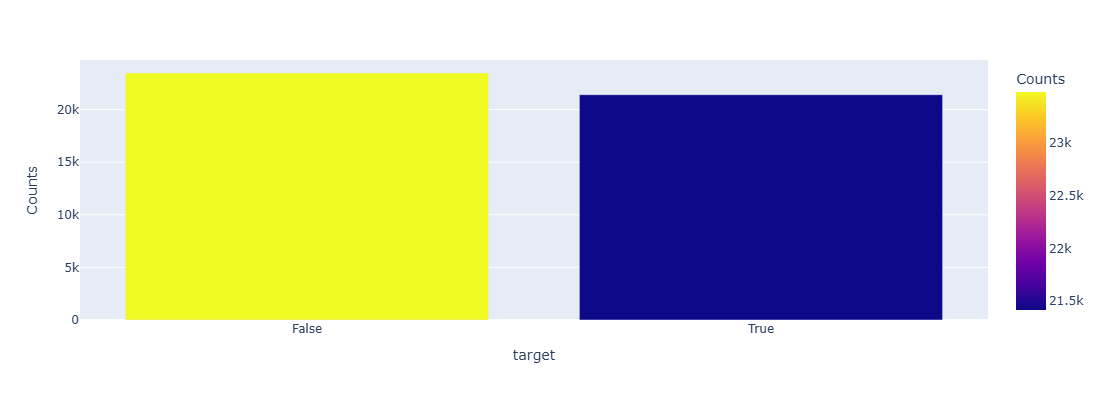

In [19]:
# What is the distribution of Subjects between the True and Fake News?
# Distribution of Subjects between True and Fake News
sub_tf_df = df.groupby('target')['title'].count().reset_index(name='Counts')

# Replace numeric targets with labels
sub_tf_df['target'] = sub_tf_df['target'].replace({0: 'False', 1: 'True'})

# Plot
fig = px.bar(sub_tf_df,
    x="target",
    y="Counts",
    color="Counts",
    barmode="group",
    height=400
)
fig.show()

# The dataset looks really balanced and hence working on this is pretty easy. 
# Thus we need not work on to make this dataset more balanced, and can safely assume this is a balanced dataset

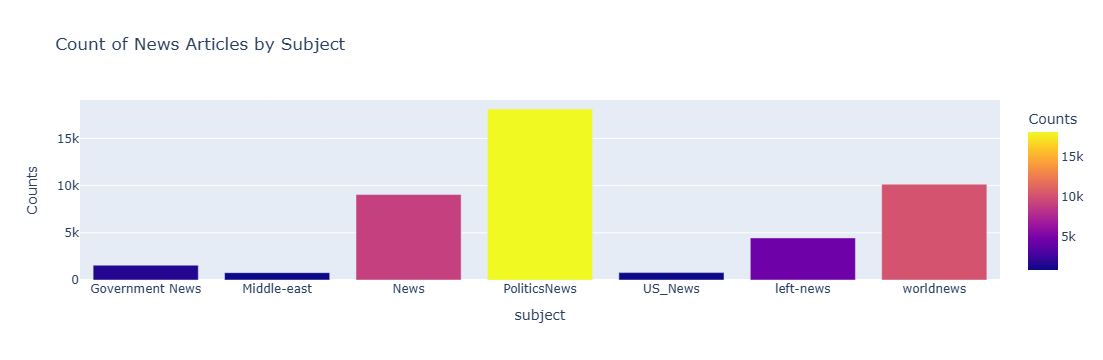

In [20]:
# Which Subjects have received the most News Coverage?
sub_check = df.groupby('subject')['title'].count().reset_index(name='Counts')

fig = px.bar(
    sub_check,
    x='subject',
    y='Counts',
    color='Counts',
    title='Count of News Articles by Subject'
)

fig.show()

# Observations Political News and World News hold the most domination counts in the data set that we have considered.

In [21]:
# Can the News Headline be enough to predict if the news if fake or not? Let us see in the following analysis
df['clean_title'] = df['title'].apply(preprocess)
df['clean_title'][0]

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script']

In [22]:
df['clean_joined_title']=df['clean_title'].apply(lambda x:" ".join(x))  # joins the words in the list into a single string

# Accuracy we can predict if the News is True or Fake just from the Title?

In [24]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\savee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\savee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

The maximum number of words in a title is = 34


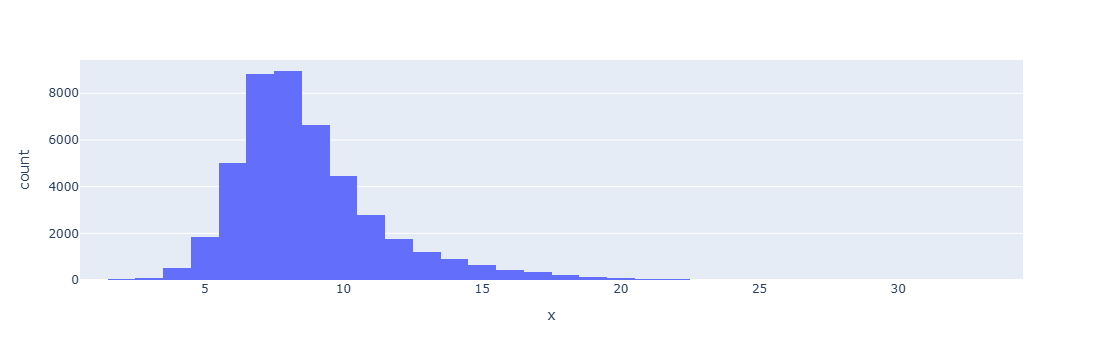

In [25]:
maxlen = -1
for doc in df.clean_joined_title:
    tokens = nltk.word_tokenize(doc)  # break the string into individual words (tokens).
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in a title is =", maxlen)
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined_title], nbins = 50)
#For each title x, it tokenizes the title into words using nltk.word_tokenize(x) and calculates the length of the resulting token list , which is the number of words in the title.
#The result is a list of word counts for each title.

fig.show()

#On an average, The maximum number of titles range between 7-8 words. Would be a bit tricky to judge if the news if true or fake 
#only with these few words. So we hope we shall not be getting a great amount of accuracy using the title alone. 

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_title, df.target, test_size = 0.2,random_state=2)
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)
#CountVectorizer().fit(X_train): Learns the vocabulary of words in the training data.
#transform(X_train) and transform(X_test): Converts the text data into numerical form (sparse matrices of word counts) 
#based on the vocabulary learned from the training data. This prepares the data for use in machine learning models.
#The transformed matrices (X_vec_train and X_vec_test) can now be fed into a classifier for model training and evaluation.

In [27]:
model = LogisticRegression(C=2)   #classification algorithm for multiclass or binary classification
model.fit(X_vec_train, y_train)
predicted_value = model.predict(X_vec_test)
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)

# c=2 , It is a hyperparameter for To control regularisation(which helps prevents overfitting) .
#In this case, setting C=2 indicates a relatively weaker regularization
#Overfitting happens when a model learns the details and noise in the training data so well that 
#it performs poorly on new, unseen data


# 94.73% accuarte prediction is a good result.

0.9473395582912705


<Axes: >

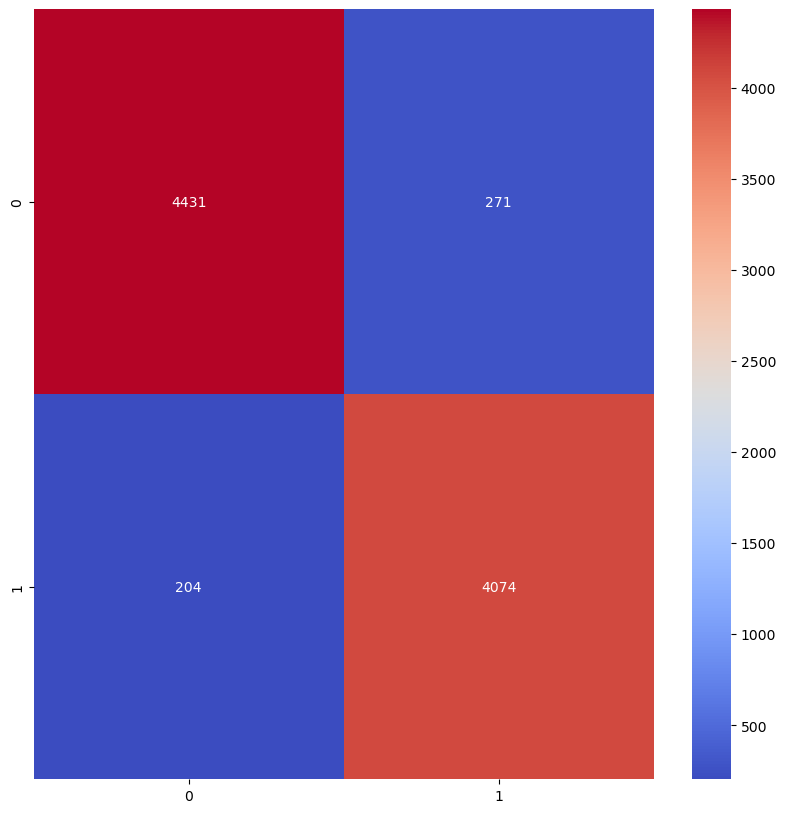

In [28]:
# 94.73% accuarte prediction is a good result. 
# Confusion Matrix for this model using just the title

cm = confusion_matrix(list(y_test), predicted_value)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g',cmap="coolwarm")

In [29]:
# Check if the Content of the News is enough to predict if the news if fake or not
df['clean_text'] = df['text'].apply(preprocess)
df['clean_joined_text']=df['clean_text'].apply(lambda x:" ".join(x))

The maximum number of words in a News Content is = 4573


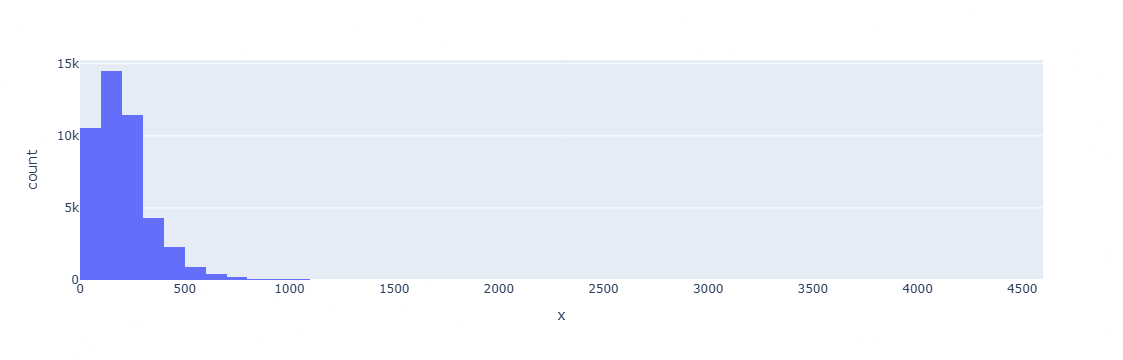

In [30]:
# distribution of word counts in the texts
maxlen = -1
for doc in df.clean_joined_text:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in a News Content is =", maxlen)
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined_text], nbins = 50)
fig.show()

# As we can see most of the News articles are within a range of 100-200 words. Anything beyond this point is not very catchy, 
# and even the media tends to avoid. But yes when the number of words are such large, it will be much easier for the model to predict. 
# the newer accuracy is much more than the Title model.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_text, df.target, test_size = 0.2,random_state=2)
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)
model = LogisticRegression(C=2.5)
model.fit(X_vec_train, y_train)
predicted_value = model.predict(X_vec_test)
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)

# 99.50% Much better than predicting from only titles. 

0.9950154997555077


<Axes: >

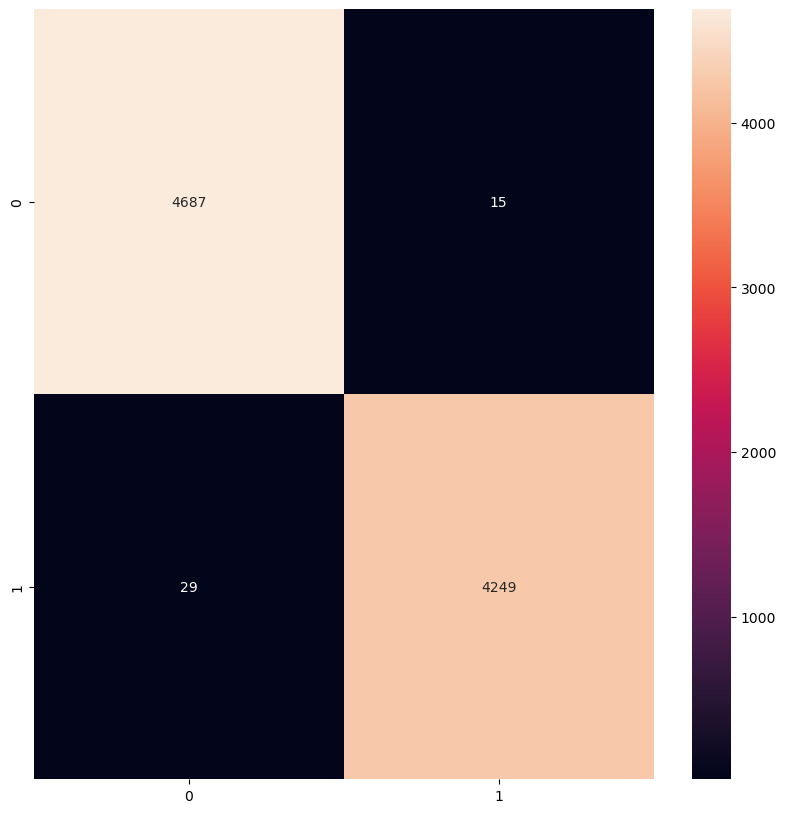

In [32]:
prediction = []
for i in range(len(predicted_value)):
    if predicted_value[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g')

# This is Better, 4662 Contents of Fake News were classified as Fake, while 4281 Real ones were rightly predicted as well. 
# Now we have only 41 missclassified sets.

In [33]:
# Analyzing getting both title and content both
df['clean_final'] = df['original'].apply(preprocess)
df['clean_joined_final']=df['clean_final'].apply(lambda x:" ".join(x))

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_final, df.target, test_size = 0.2,random_state=0)
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)
model = LogisticRegression(C=3)
model.fit(X_vec_train, y_train)
predicted_value = model.predict(X_vec_test)
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)

# 99.64%!!! So considering both the title and the content of the news we have been able to predict the nature of the news! 

0.9964307894096196


<Axes: >

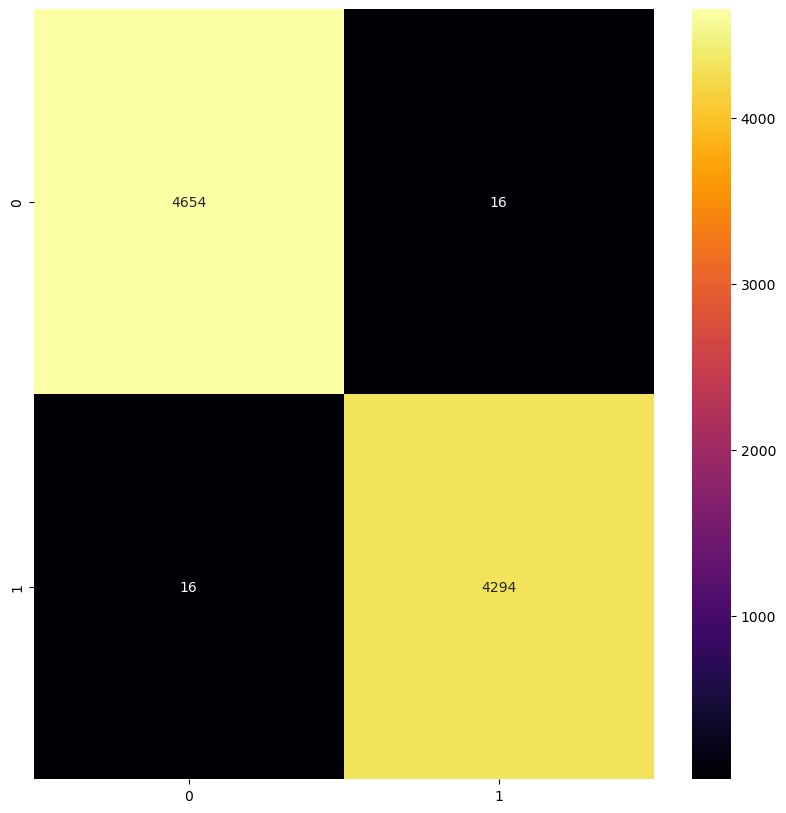

In [35]:
prediction = []
for i in range(len(predicted_value)):
    if predicted_value[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g',cmap='inferno')

In [36]:
from sklearn.metrics import classification_report

In [37]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4670
           1       1.00      1.00      1.00      4310

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [38]:
X_new=X_vec_test[45]
predictions=model.predict(X_new)
print(predictions)

if (predictions==0):
    print('The news is fake')
else:
    print('The news is real')

[1]
The news is real


In [39]:
X_new=X_vec_test[2345]
predictions=model.predict(X_new)
print(predictions)

if (predictions==0):
    print('The news is fake')
else:
    print('The news is real')

[0]
The news is fake


In [40]:
X_new=X_vec_test[134]
predictions=model.predict(X_new)
print(predictions)

if (predictions==0):
    print('The news is fake')
else:
    print('The news is real')

[0]
The news is fake


In [41]:
X_new=X_vec_test[710]
predictions=model.predict(X_new)
print(predictions)

if (predictions==0):
    print('The news is fake')
else:
    print('The news is real')

[1]
The news is real


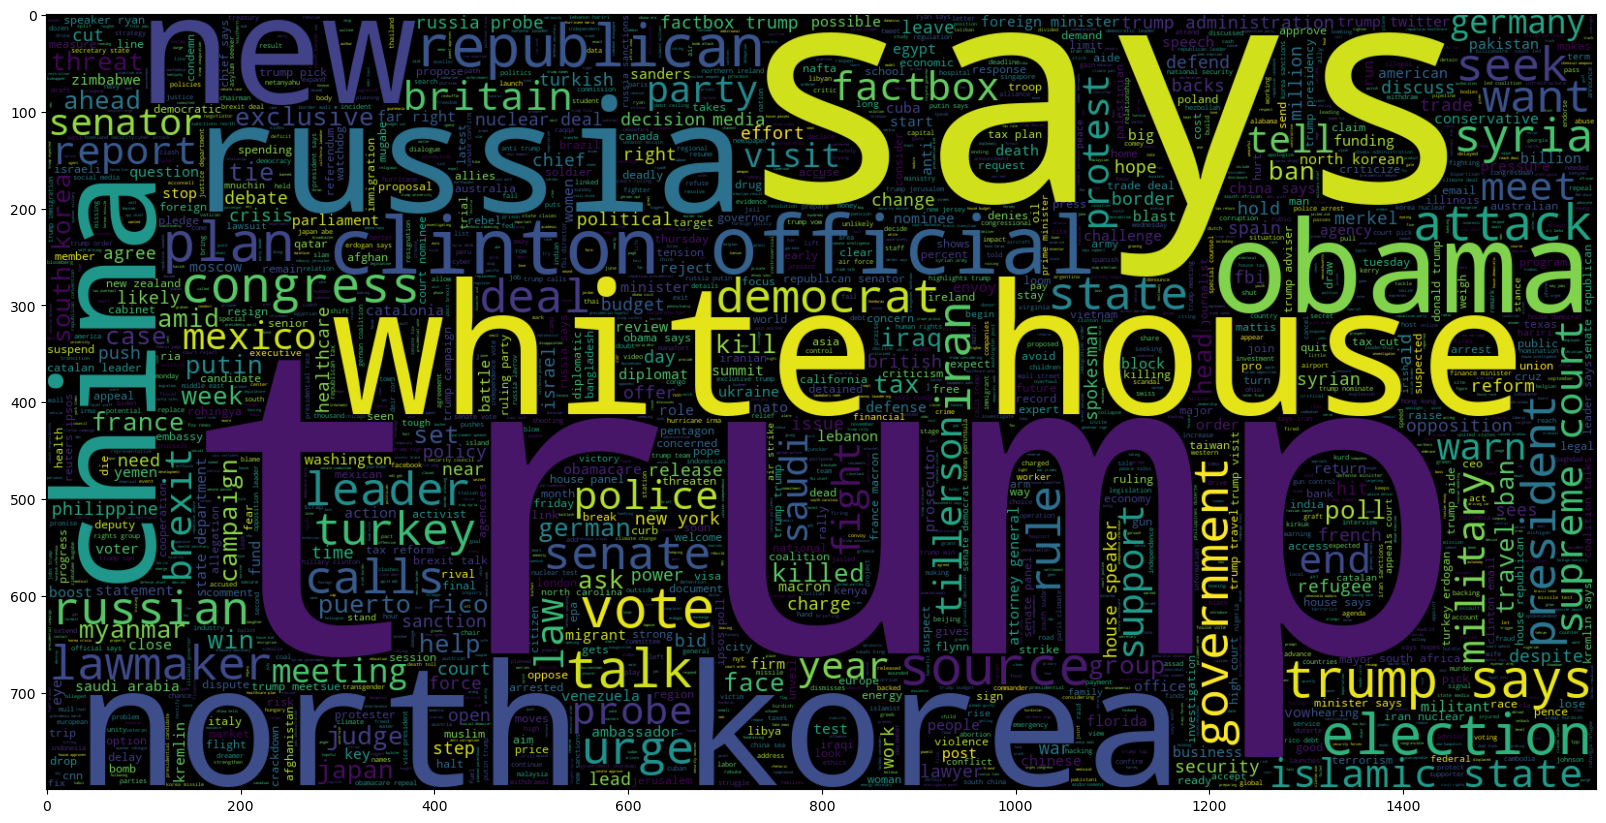

In [43]:
# WordCloud for True news
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 1].clean_joined_title))
plt.imshow(wc, interpolation = 'bilinear')

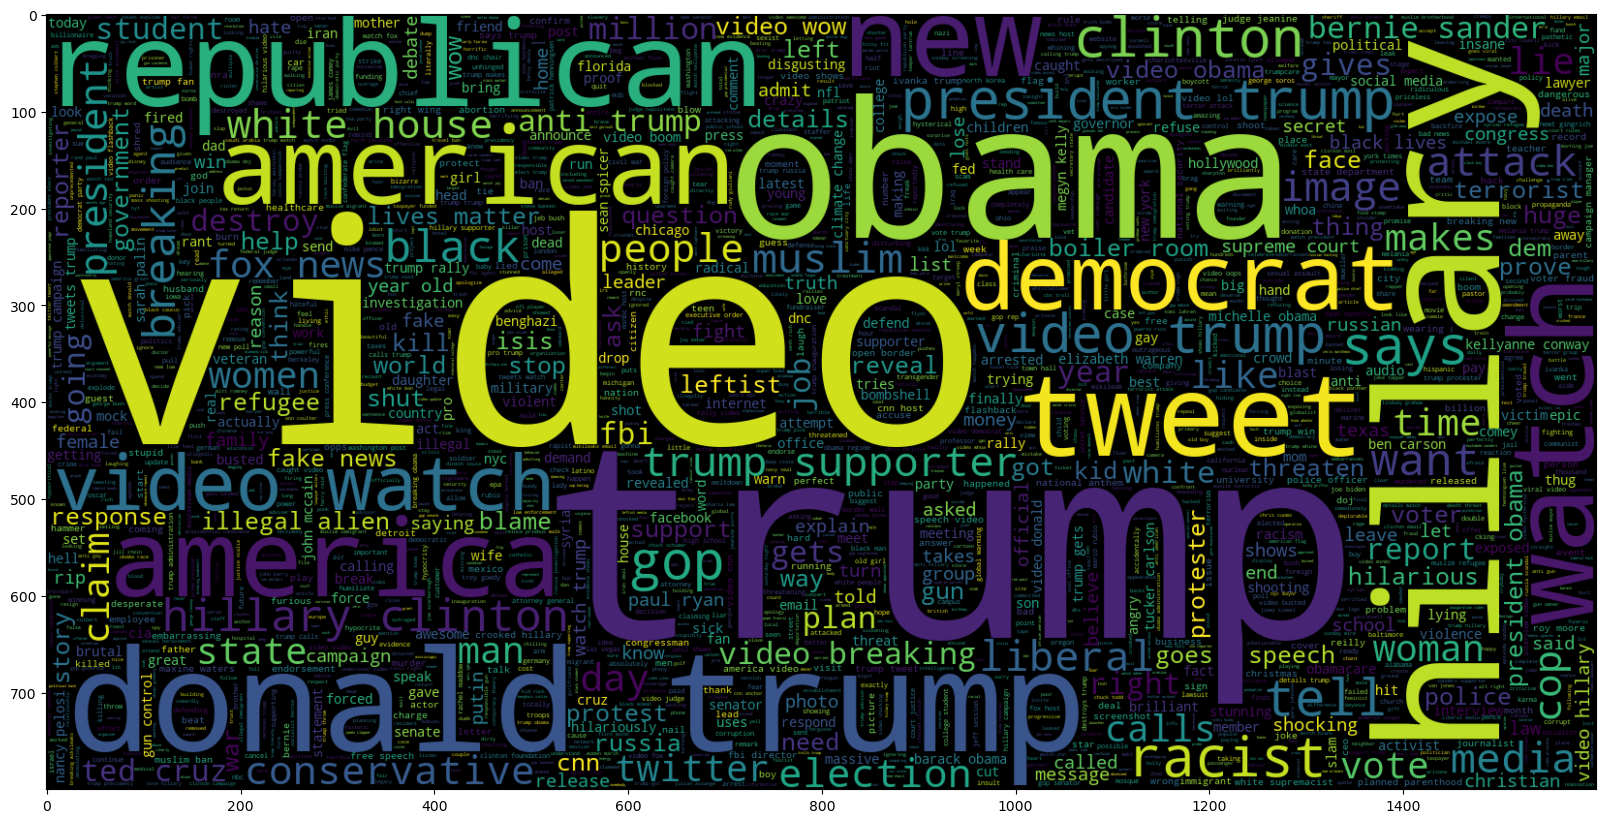

In [44]:
# wordcloud for FakeNews
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 0].clean_joined_title))
plt.imshow(wc, interpolation = 'bilinear')

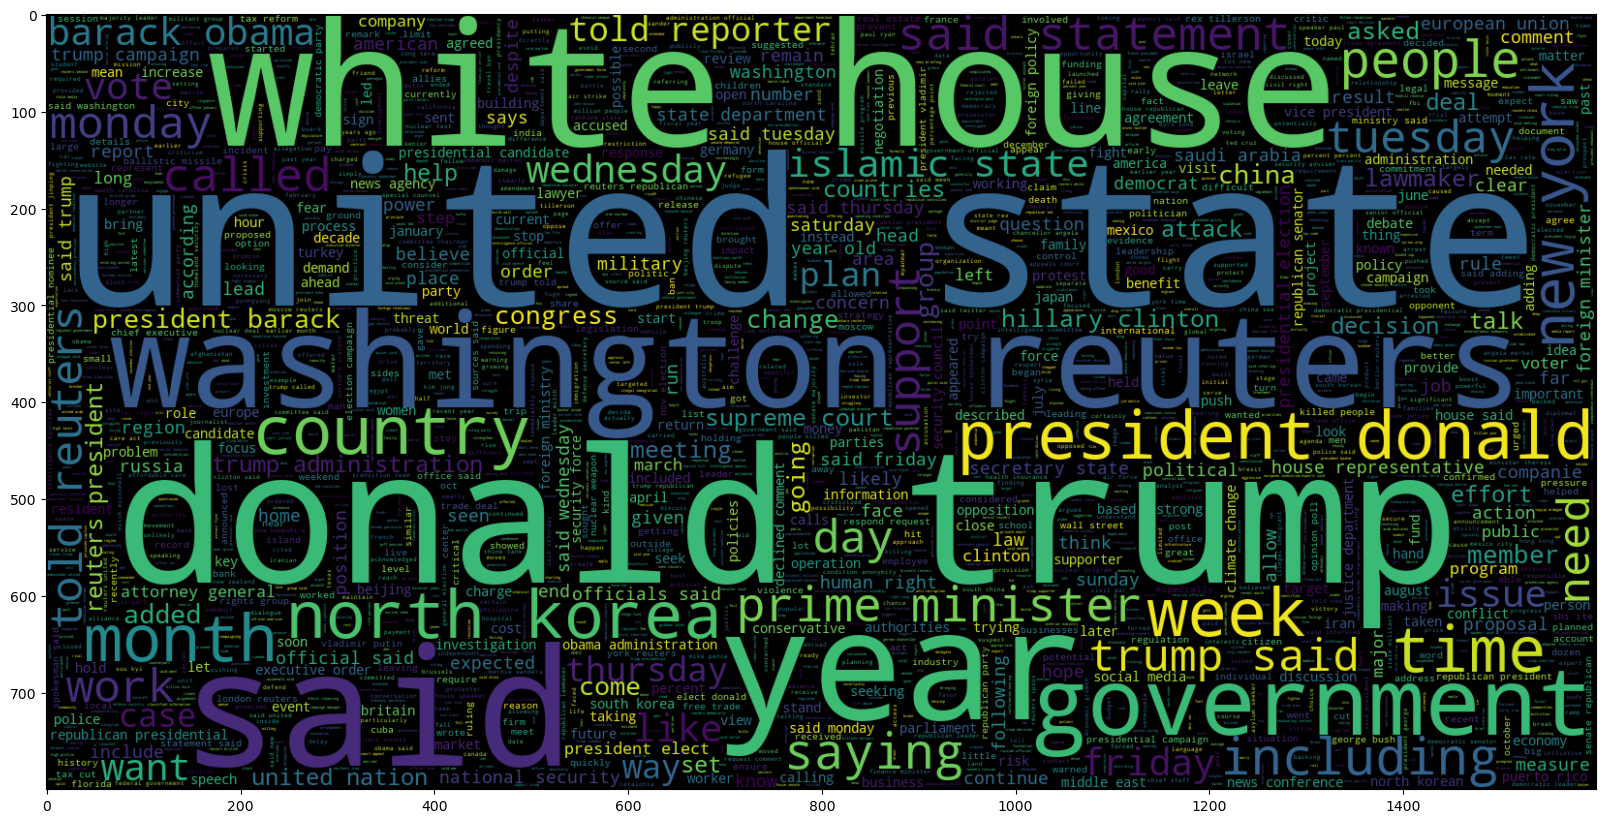

In [45]:
# WordCloud for True newsS
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 1].clean_joined_text))
plt.imshow(wc, interpolation = 'bilinear')

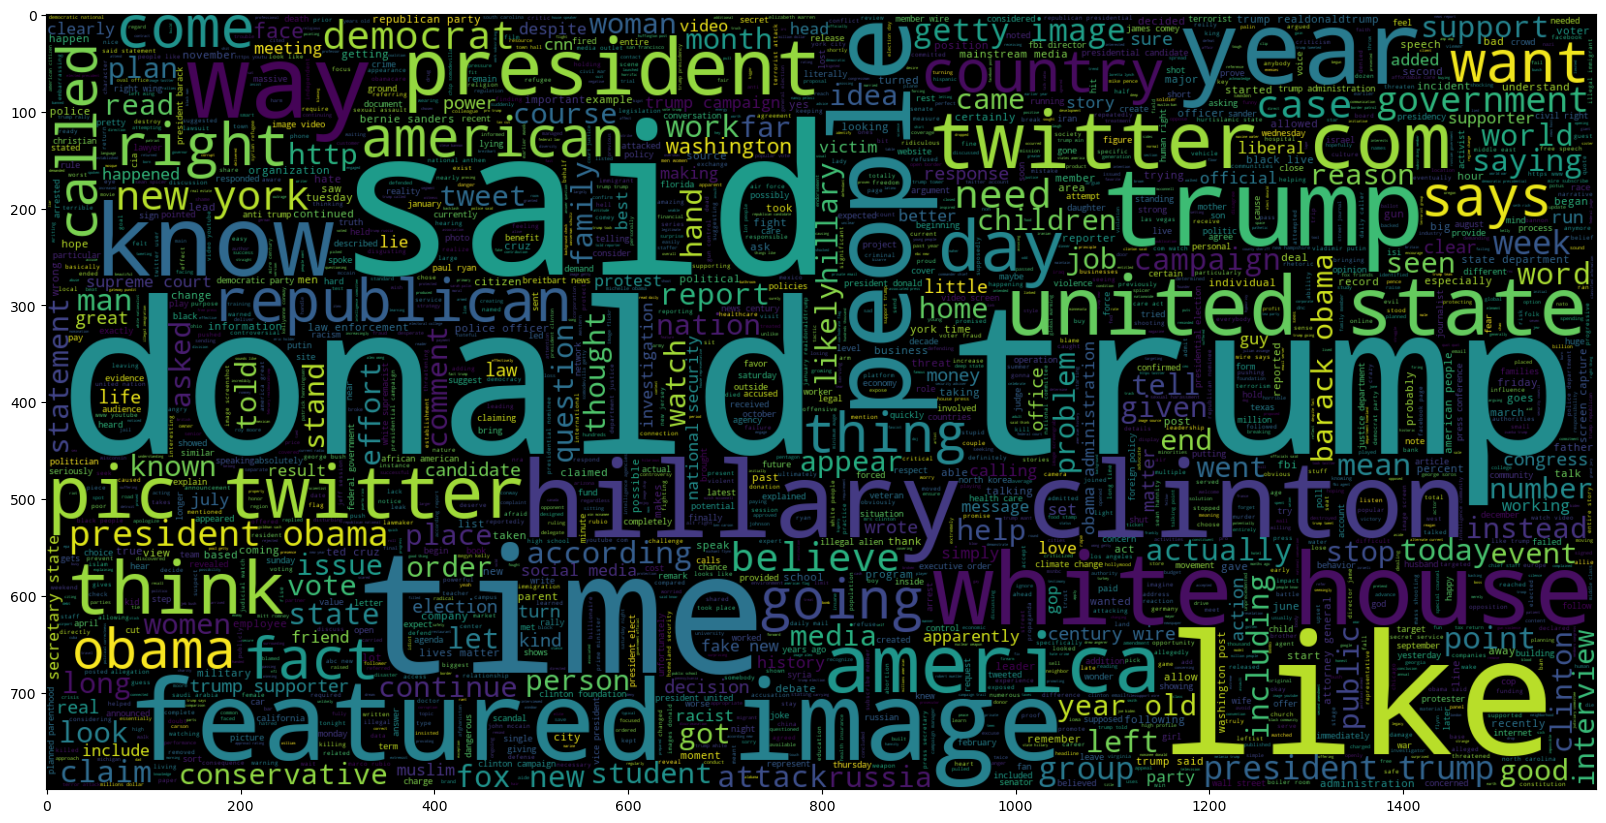

In [46]:
# WordCloud for Fake news
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 0].clean_joined_text))
plt.imshow(wc, interpolation = 'bilinear')